In this section, we cover serving machine learning models in production. We will explore the TensorFlow Serving components of the **TensorFlow Extended (TFX)** platform. TFX is an MLOps tool that builds complete, end-to-end machine learning pipelines for scalable and high-performance model tasks. A TFX pipeline is composed of a sequence of components for data validation, data transformation, model analysis, and model serving. In this recipe, we will focus on the last component, which can support model versioning, multiple models, and so on.

## Getting ready...

It is advised to read over the official documentation and the short tutorials on the TFX site: https://www.tensorflow.org/tfx

For this example, we will build an MNIST model, save it, download the TensorFlow Serving Docker image, run it, and send POST requests to the REST server in order to get some image predictions.

## How to do it...

1. Load our libraries

In [17]:
import tensorflow as tf
import numpy as np
import requests
import matplotlib.pyplot as plt
import json

2. Build our MNIST model

In [18]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize
x_train = x_train / 255
x_test = x_test/ 255

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(name="FLATTEN"))
model.add(tf.keras.layers.Dense(units=128 , activation="relu", name="D1"))
model.add(tf.keras.layers.Dense(units=64 , activation="relu", name="D2"))
model.add(tf.keras.layers.Dense(units=10, activation="softmax", name="OUTPUT"))
    
model.compile(optimizer="sgd", 
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"]
             )

model.fit(x=x_train, 
          y=y_train, 
          epochs=5,
          validation_data=(x_test, y_test)
         )

Epoch 1/5
1875/1875 [==============================] - 2s 892us/step - loss: 0.5983 - accuracy: 0.8392 - val_loss: 0.3101 - val_accuracy: 0.9090
Epoch 2/5
1875/1875 [==============================] - 2s 839us/step - loss: 0.2899 - accuracy: 0.9175 - val_loss: 0.2527 - val_accuracy: 0.9285
Epoch 3/5
1875/1875 [==============================] - 2s 855us/step - loss: 0.2380 - accuracy: 0.9315 - val_loss: 0.2170 - val_accuracy: 0.9364
Epoch 4/5
1875/1875 [==============================] - 2s 849us/step - loss: 0.2035 - accuracy: 0.9416 - val_loss: 0.1881 - val_accuracy: 0.9442
Epoch 5/5
1875/1875 [==============================] - 2s 843us/step - loss: 0.1778 - accuracy: 0.9493 - val_loss: 0.1707 - val_accuracy: 0.9509


3. We then save our model as the SavedModel format and create a directory for each version of our model.

In [19]:
# Build a model directory
!mkdir "my_mnist_model"

# Build a directory with the version 1
!mkdir "my_mnist_model/1"

In [20]:
# Save the model
model.save("my_mnist_model/1")

INFO:tensorflow:Assets written to: my_mnist_model/1/assets


INFO:tensorflow:Assets written to: my_mnist_model/1/assets


4. We'll now install TensorFlow serving using Docker.

In [21]:
! docker pull tensorflow/serving

Using default tag: latest
latest: Pulling from tensorflow/serving
Digest: sha256:6651f4839e1124dbde75ee531825112af0a6b8ef082c88ab14ca53eb69a2e4bb
Status: Image is up to date for tensorflow/serving:latest
docker.io/tensorflow/serving:latest


5. We can now start a Docker container. We will:  
- publish the REST API port to our host's port 8501  
- take the previous model my_mnist_model  
- bind it to the model base path /models/my_mnist_model  
- fill the environment variable MODEL_NAME with my_mnist_model

Run the following command from command line while in this working directory:

docker run -p 8501:8501 \  
--mount type=bind,source="$(pwd)/my_mnist_model/",target=/models/my_mnsit_model \  
-e MODEL_NAME=my_mnist_model -t tensorflow/serving

5. We can now display our images that we want to predict:

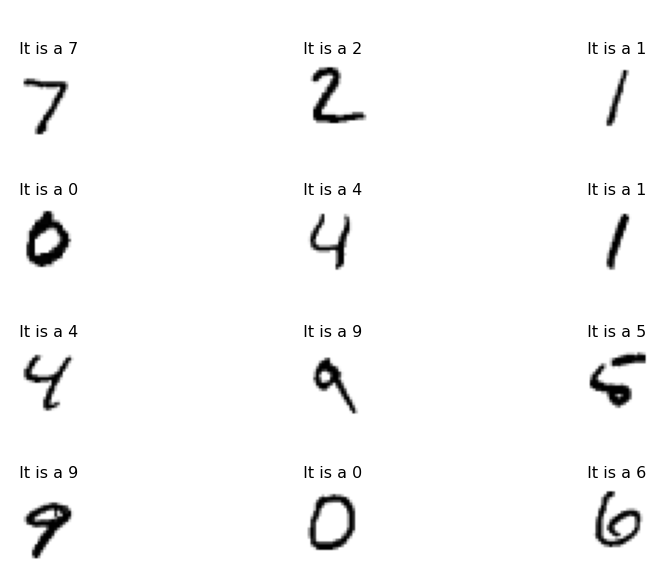

In [22]:
num_rows = 4
num_cols = 3
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for row in range(num_rows):
    for col in range(num_cols):
        index = num_cols * row + col
        image = x_test[index]
        true_label = y_test[index]
        plt.subplot(num_rows, 2*num_cols, 2*index+1)
        plt.imshow(image.reshape(28,28), cmap='binary')
        plt.axis('off')
        plt.title('\n\n It is a {}'.format(y_test[index]), fontdict={'size': 16})
plt.tight_layout()
plt.show()

6. We'll now submit binary data to the \< host \>:8501 and get back the JSON response showing the results. It is possible to do this via any machine and with any programming language. The ability to not have to rely on the client to have a local copy of TensorFlow is very useful.  
  
Here, we will send POST predict requests to our server and pass the images. The server will return 10 probabilities for each image corresponding to the probability for each digit between 0 and 9:

In [23]:
json_request = '{{ "instances" : {} }}'.format(x_test[0:12].tolist())
resp = requests.post('http://localhost:8501/v1/models/my_mnist_model:predict', data=json_request, headers = {"content-type": "application/json"})
print('response.status_code: {}'.format(resp.status_code))     
print('response.content: {}'.format(resp.content))
predictions = json.loads(resp.text)['predictions']

response.status_code: 200
response.content: b'{\n    "predictions": [[1.34525862e-05, 6.37046787e-06, 0.00136343646, 0.0060114339, 2.76316882e-06, 1.19726483e-05, 1.37090783e-08, 0.992200792, 5.43402239e-05, 0.000335545454], [0.000247486721, 0.000473293738, 0.993475139, 0.0034292955, 9.1623753e-10, 0.000419283402, 0.00162787549, 1.10146869e-09, 0.000327551592, 3.60294e-10], [1.23620057e-05, 0.987666965, 0.00382557604, 0.00185972021, 0.000438506337, 0.00106538553, 0.000849552918, 0.00220670085, 0.00177960447, 0.000295502716], [0.998975754, 1.28716124e-07, 0.000681473233, 1.86333637e-05, 3.59319927e-07, 3.81722639e-05, 0.000162767319, 0.000102746359, 1.75934167e-06, 1.82998701e-05], [0.000648092129, 4.03315516e-06, 0.000420053228, 4.93106672e-05, 0.949111283, 0.000927347457, 0.0014790874, 0.00198606704, 0.00171432144, 0.0436604582], [9.43909413e-07, 0.997132659, 0.000270127464, 0.000409833825, 0.000126902363, 5.70285665e-05, 2.97884017e-05, 0.00158443442, 0.000264133065, 0.000124042373],

7. We can now display the results of our predictions for our images:

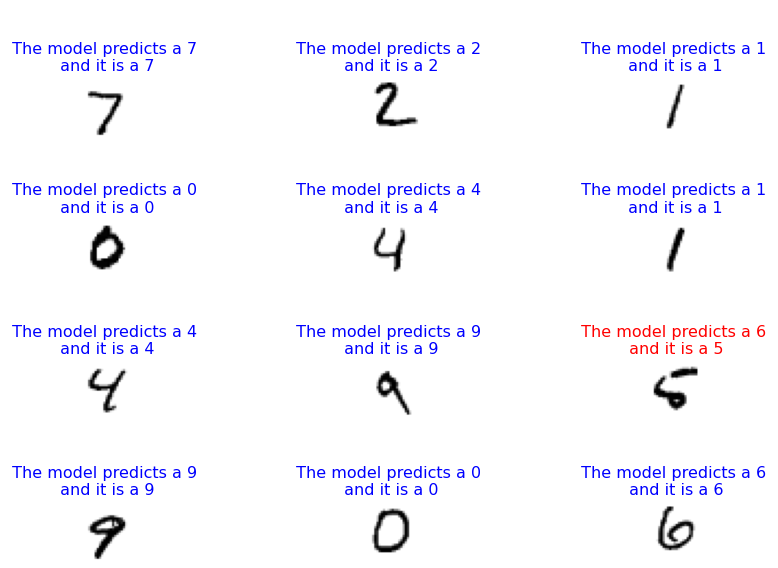

In [24]:
num_rows = 4
num_cols = 3
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for row in range(num_rows):
    for col in range(num_cols):
        index = num_cols * row + col
        image = x_test[index]
        predicted_label = np.argmax(predictions[index])
        true_label = y_test[index]
        plt.subplot(num_rows, 2*num_cols, 2*index+1)
        plt.imshow(image.reshape(28,28), cmap='binary')
        plt.axis('off')
        if predicted_label == true_label:
            color='blue'
        else:
            color='red'
        plt.title('\n\n The model predicts a {} \n and it is a {}'.format(predicted_label, true_label), 
                                                                          fontdict={'size': 16}, color=color)
plt.tight_layout()
plt.show()

Not bad results! Except for the 5 that is sloppy, the model predicted everything correctly.

8. The final step is to shutdown our docker container.

In [25]:
! docker ps

CONTAINER ID   IMAGE                COMMAND                  CREATED              STATUS              PORTS                                                 NAMES
c5349e05e084   tensorflow/serving   "/usr/bin/tf_serving…"   About a minute ago   Up About a minute   8500/tcp, 0.0.0.0:8501->8501/tcp, :::8501->8501/tcp   amazing_carson


In [26]:
! docker kill c5349e05e084

c5349e05e084


That concludes this recipe and the cookbook!